## Algorithm for efficient vector overlay of a polygon representation over a regular grid

* [Environment settings](#Settings): for the notebook to run...
* [Dummy proxy datasets](#Datasets): we prepare some "proxy" data for testing, you can skip this section (still have to run it)...
* Vector layers overlay: [Workable solution](#Solution): what needs to be done conceptually
* Vector layers overlay: [Practical implementation / Algorithm](#Algorithm): what needs to be done in practice owing to computational limitations

### Settings<a id='Settings'></a>

In [1]:
THISDIR = !pwd
import os, sys
import requests
import numpy as np
import pandas as pd

In [2]:
try:
    import matplotlib
except ImportError:
    raise IOError("Guess what: you're doomed...")
else:
    import matplotlib.pyplot as mplt
finally:
    _FIGSIZE_, _DPI_ = (10,8), 140 
%matplotlib inline

I use the *Python* libraries [`shapely`](https://shapely.readthedocs.io/en/latest/manual.html) and [`geopandas`](https://geopandas.org)  because it already implements [basic set operations](https://geopandas.org/set_operations.html) as well as [spatial indexing](https://geopandas.org/mergingdata.html?highlight=spatial%20index) through the [R-Tree algorithm](https://automating-gis-processes.github.io/site/notebooks/L3/spatial_index.html). 

The implementations are certainly not optimal. Actually, they are wrappers to the [GEOS library](https://trac.osgeo.org/geos/), itself a port of the Java Topology Suite ([JTS](https://projects.eclipse.org/projects/locationtech.jts)). You can find similar implementations in *R* through the [sf](https://r-spatial.github.io/sf/) library for instance. That's also what is used in QGis. 

In [3]:
try:
    import shapely
except ImportError:
    try:
        !{sys.executable} -m pip install shapely
    except:
        print("! Error !")
else:
    from shapely import geometry 
try:
    import geopandas as gpd
except ImportError:
    try:
        !{sys.executable} -m pip install geopandas
    except:
        print("! Error !")

Looking at the same area:

In [4]:
BE = {'BE': 'Belgium'}

### Dummy proxy datasets (ignore!) <a id='Datasets'></a>

Don't pay attention here. I just download some 'proxy' data
* a set of NUTS regions, that will be regarded as the non-ovelapping poygonal representation (likewise Proximus data),
* the boundaries of BE area.

and I will create another one:
* regular polygonal grid over that same area.

In [5]:
IPROJ = '3035' # that's LAEA, but whatever works... we can still (re)project

FMT = 'geojson'
RES = 20
gisco_domain = 'https://ec.europa.eu/eurostat/cache/GISCO/distribution/v2/nuts/download'
gisco_rest = 'https://gisco-services.ec.europa.eu/distribution/v2'

ctry_domain = 'countries'
ctry_year = 2020

ctry_name = '{}-region-%sm-%s-%s.%s' % (RES, IPROJ, ctry_year, FMT)
ctry_site = '%s/%s/%s-%s-units.html' % (gisco_rest, ctry_domain, ctry_domain, ctry_year)
ctry_file = '%s/%s/%s/%s' % (gisco_rest, ctry_domain, 'distribution', ctry_name)

In [6]:
ctry_file = ctry_file.format(next(iter(BE.keys())))
ctry_name = ctry_name.format(next(iter(BE.keys())))

try:
    print("Fetching data: %s" % ctry_file)
    resp = requests.get(ctry_file)
    resp.raise_for_status()
except:
    raise IOError("Error fetching data...")
else:
    !wget -O $ctry_name "$ctry_file"
    print('Country data (= dissolved representation) loaded on disk: \033[1m%s\033[0m' % os.path.join(THISDIR[0],ctry_name))

Fetching data: https://gisco-services.ec.europa.eu/distribution/v2/countries/distribution/BE-region-20m-3035-2020.geojson
--2020-05-19 17:22:31--  https://gisco-services.ec.europa.eu/distribution/v2/countries/distribution/BE-region-20m-3035-2020.geojson
Resolving gisco-services.ec.europa.eu (gisco-services.ec.europa.eu)... 40.113.93.170
Connecting to gisco-services.ec.europa.eu (gisco-services.ec.europa.eu)|40.113.93.170|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1902 (1.9K)
Saving to: ‘BE-region-20m-3035-2020.geojson’

BE-region-20m-3035- 100%[===================>]   1.86K  --.-KB/s    in 0s      

2020-05-19 17:22:31 (53.3 MB/s) - ‘BE-region-20m-3035-2020.geojson’ saved [1902/1902]

Country data (= dissolved representation) loaded on disk: /Users/gjacopo/Developments/bodylanguage/BE-region-20m-3035-2020.geojson


In [7]:
border = gpd.read_file(os.path.join(THISDIR[0],ctry_name), driver='GeoJSON')
print("Projection system") 
border.crs

Projection system


<Projected CRS: EPSG:3035>
Name: ETRS89-extended / LAEA Europe
Axis Info [cartesian]:
- Y[north]: Northing (metre)
- X[east]: Easting (metre)
Area of Use:
- name: Europe - LCC & LAEA
- bounds: (-35.58, 24.6, 44.83, 84.17)
Coordinate Operation:
- name: Europe Equal Area 2001
- method: Lambert Azimuthal Equal Area
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

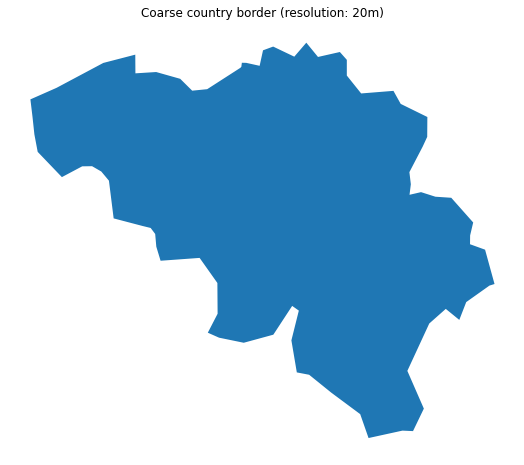

In [8]:
f, ax = mplt.subplots(1, figsize=_FIGSIZE_)
border.plot(ax=ax)
ax.set_axis_off(); ax.set_title('Coarse country border (resolution: %sm)' % RES)
mplt.show()

In [9]:
nuts_domain = 'nuts'
nuts_year = 2021
nuts_level = 3

nuts_name = 'NUTS_RG_%sM_%s_%s_LEVL_%s.%s' % (RES, nuts_year, IPROJ, nuts_level, FMT)
nuts_site = '%s/%s/%s-%s-units.html' % (gisco_rest, nuts_domain, nuts_domain,  nuts_year)
nuts_file = '%s/%s/%s/%s' % (gisco_rest, nuts_domain, FMT, nuts_name)

In [10]:
try:
    print("Fetching data: %s" % nuts_file)
    resp = requests.get(nuts_file)
    resp.raise_for_status()
except:
    raise IOError("Error fetching data...")
else:
    !wget -O $nuts_name "$nuts_file"
    print('Reginal data (= polygon representation) loaded on disk: \033[1m%s\033[0m' % os.path.join(THISDIR[0],nuts_name))

Fetching data: https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_20M_2021_3035_LEVL_3.geojson
--2020-05-19 17:22:33--  https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_20M_2021_3035_LEVL_3.geojson
Resolving gisco-services.ec.europa.eu (gisco-services.ec.europa.eu)... 40.113.93.170
Connecting to gisco-services.ec.europa.eu (gisco-services.ec.europa.eu)|40.113.93.170|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 955102 (933K)
Saving to: ‘NUTS_RG_20M_2021_3035_LEVL_3.geojson’

NUTS_RG_20M_2021_30 100%[===================>] 932.72K  2.62MB/s    in 0.3s    

2020-05-19 17:22:34 (2.62 MB/s) - ‘NUTS_RG_20M_2021_3035_LEVL_3.geojson’ saved [955102/955102]

Reginal data (= polygon representation) loaded on disk: /Users/gjacopo/Developments/bodylanguage/NUTS_RG_20M_2021_3035_LEVL_3.geojson


In [11]:
polygons = gpd.read_file(os.path.join(THISDIR[0], nuts_name), driver='GeoJSON')
print("Projection system:")
polygons.crs

Projection system:


<Projected CRS: EPSG:3035>
Name: ETRS89-extended / LAEA Europe
Axis Info [cartesian]:
- Y[north]: Northing (metre)
- X[east]: Easting (metre)
Area of Use:
- name: Europe - LCC & LAEA
- bounds: (-35.58, 24.6, 44.83, 84.17)
Coordinate Operation:
- name: Europe Equal Area 2001
- method: Lambert Azimuthal Equal Area
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [12]:
polygons = polygons.loc[polygons.FID.apply(lambda x: x.startswith('BE'))] 
polygons.head(5)

,id,COAST_TYPE,MOUNT_TYPE,NAME_LATN,CNTR_CODE,FID,NUTS_ID,NUTS_NAME,LEVL_CODE,URBN_TYPE,geometry
321,BE100,None,None,Arr. de Bruxelles-Capitale/Arr. Brussel-Hoofdstad,BE,BE100,BE100,Arr. de Bruxelles-Capitale/Arr. Brussel-Hoofdstad,3,None,"POLYGON ((3918540.000 3093738.000, 3919617.000..."
322,BE211,None,None,Arr. Antwerpen,BE,BE211,BE211,Arr. Antwerpen,3,None,"POLYGON ((3950634.000 3159703.000, 3955443.000..."
323,BE212,None,None,Arr. Mechelen,BE,BE212,BE212,Arr. Mechelen,3,None,"POLYGON ((3955879.000 3116089.000, 3937267.000..."
324,BE213,None,None,Arr. Turnhout,BE,BE213,BE213,Arr. Turnhout,3,None,"POLYGON ((3980659.000 3157888.000, 3980658.000..."
325,BE224,None,None,Arr. Hasselt,BE,BE224,BE224,Arr. Hasselt,3,None,"POLYGON ((4013903.000 3107852.000, 4011003.000..."


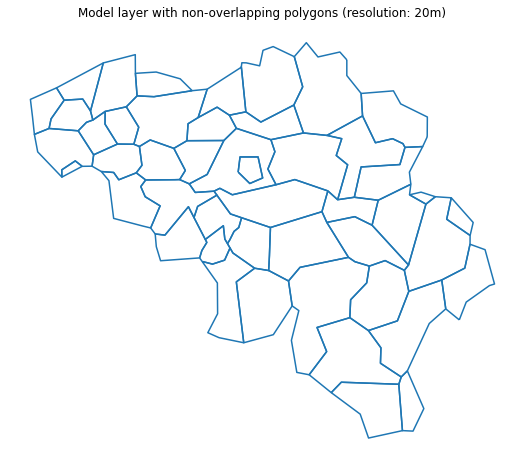

In [13]:
f, ax = mplt.subplots(1, figsize=_FIGSIZE_)
polygons.boundary.plot(ax=ax)
ax.set_axis_off(); ax.set_title('Model layer with non-overlapping polygons (resolution: %sm)' % RES)
mplt.show()

Given the polygonal representation, define a regular grid over the bounding box (considering coordinates in LAEA are expressed in m):

In [14]:
xmin, ymin, xmax, ymax = bounds = polygons.total_bounds
print("Bounding box coordinates: Xmin=%s, Ymin=%s, Xmax=%s, Ymax=%s" % (xmin,ymin,xmax,ymax))
print("------------ extent: X: %sm (%skm) -- Y: %sm (%skm)" % 
      (xmax-xmin, round((xmax-xmin)/1000), ymax-ymin, round((ymax-ymin)/1000)))

Bounding box coordinates: Xmin=3799789.0, Ymin=2941705.0, Xmax=4065087.0, Ymax=3167694.0
------------ extent: X: 265298.0m (265.0km) -- Y: 225989.0m (226.0km)


Say we are interested in a grid of 125m x 125m. We can create the grid programmatically, also adding a buffer (some issue apparently with the `total_bounds` estimation). For this example, we simplify the calculation to a 10km x 10km grid:

Grid series shape: (725, 1)
Grid actual shape: (23, 27)


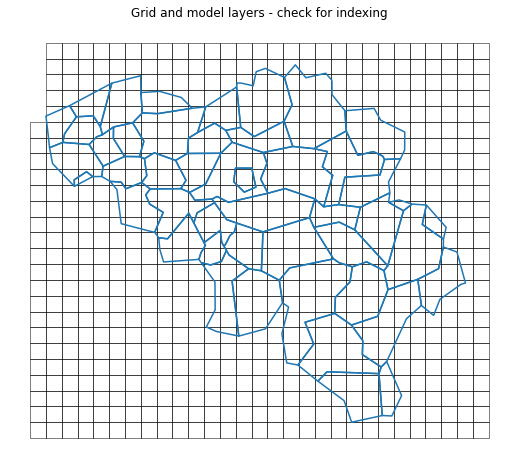

In [15]:
def get_grid_shape(gridsize, bounds, buffer=0):    
    xmin, ymin, xmax, ymax = bounds
    nrows = abs(int(np.ceil((ymax-ymin+2*buffer) / gridsize))) 
    ncols = abs(int(np.ceil((xmax-xmin+2*buffer) / gridsize))) 
    return nrows, ncols

def get_grid_size(width, height, bounds, buffer=0):   
    xmin, ymin, xmax, ymax = bounds
    cols = list(range(int(np.floor(xmin - buffer)), int(np.ceil(xmax + buffer)), width))
    rows = list(range(int(np.floor(ymin - buffer)), int(np.ceil(ymax + buffer)), height))
    rows.reverse()
    return cols, rows

def build_regular_grid(gridsize, bounds, buffer=None, crs=None): 
    buffer = gridsize if buffer is True else (0 if buffer in (False,None) else buffer)
    width = height = gridsize
    cols, rows = get_grid_size(width, height, bounds, buffer) 
    polygrid = []
    [polygrid.append(geometry.Polygon([(x,y+height), (x+width,y+height), (x+width,y), (x,y)])) 
         for x in cols for y in rows] # note the order: cols then rows
    grid = gpd.GeoDataFrame({'geometry':polygrid})
    if crs is not None:
        grid.crs = crs
    return grid

BUFFER = True
GRIDSIZE = 10 * 1000
%timeit 
grid = build_regular_grid(GRIDSIZE, [xmin, ymin, xmax, ymax], 
                          buffer=BUFFER, crs = polygons.crs)

print('Grid series shape:', grid.shape)
print('Grid actual shape:', get_grid_shape(GRIDSIZE, [xmin, ymin, xmax, ymax], BUFFER))

f, ax = mplt.subplots(1, figsize=_FIGSIZE_)
grid.geometry[5:len(grid)].boundary.plot(ax=ax, edgecolor='k', linewidth=0.5)
polygons.boundary.plot(ax=ax)
ax.set_axis_off(); ax.set_title('Grid and model layers - check for indexing')
mplt.show()

Consider however the use of the [GridMaker](https://github.com/eurostat/GridMaker) for this exercise. 

In real use-case, layers A and B are actually defined in different reference systems. Let's change the reference system of layer B and consider the projected dataset as the input for the problem:

/Library/miniconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


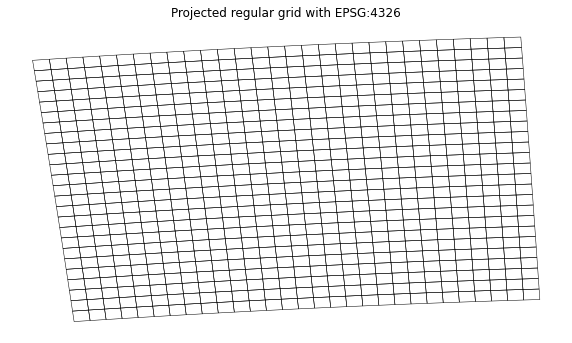

In [16]:
OPROJ = 4326
grid = grid.to_crs({'init': 'epsg:%s' % OPROJ})

f, ax = mplt.subplots(1, figsize=_FIGSIZE_)
grid.boundary.plot(ax=ax, edgecolor='k', linewidth=0.5)
ax.set_axis_off(); ax.set_title('Projected regular grid with EPSG:%s' % OPROJ)
mplt.show()

### Vector layers overlay - Workable solution<a id='Solution'></a>

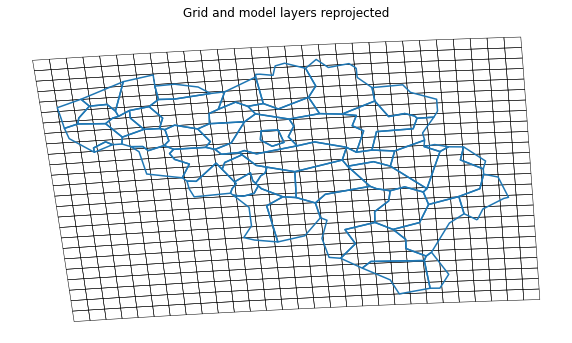

In [17]:
polygons = polygons.to_crs(grid.crs)
f, ax = mplt.subplots(1, figsize=_FIGSIZE_)
grid.geometry.boundary.plot(ax=ax, edgecolor='k', linewidth=0.5)
polygons.boundary.plot(ax=ax)
ax.set_axis_off(); ax.set_title('Grid and model layers reprojected')
mplt.show()

Say we have two vector layers "like" above:
* a non-overlapping (multi)polygonal representation 'A' (the Voronoi tesselation of the real use-case),
* a regular grid 'B' (the INSPIRE grid in real use-case),

available over the same area, at different resolutions and in different projections. 

Ultimately, we want to calculate the proportion of area of the polygons layer A that lie within the grid layer B. To do so, we will overlay the model layer A onto the grid layer B.

Conceptually, the set operation that is requested here is "union", not "intersection" (*cf.* Albrecht and Janine's approach; see for instance [overlay page in QGis](https://docs.qgis.org/3.10/en/docs/user_manual/processing_algs/qgis/vectoroverlay.html)). Because the model layer A is fully covered by the grid layer B, both set operations will produce the same topology (same polygons) in the inner part of A.  

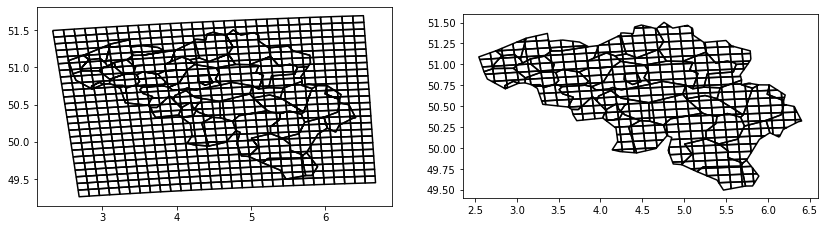

In [18]:
f, ax = mplt.subplots(1,2, figsize=(14,10))

#%timeit 
poly_union = gpd.overlay(polygons, grid, how='union')
poly_union.boundary.plot(edgecolor='k', ax=ax[0]);

#%timeit 
poly_inter = gpd.overlay(polygons, grid, how='intersection')
poly_inter.boundary.plot(edgecolor='k', ax=ax[1]);

However, they may result in different geometries. Using "union", we are ensured to create (multi)polygons only (as a union of polygons in the input layers, while intersection may result in the creation of lines features for instance. In addition, the entire grid is represented.

What we have to do is simply:
* compute the area of each polygon in the model layer A (using the area units of the output projection of B) and store it as an attribute `poly_area` in the table,
* run the "union" overlay operation of model layer A and grid layer B,
* calculate the percentage of overlap in the output union layer compared to the entire area of the model layer as the ratio `(uarea/poly_area)`, where `uarea` is the area of the newly created vector featues:

In [19]:
polygons['poly_area'] = polygons.area
polygons.head(5)

,id,COAST_TYPE,MOUNT_TYPE,NAME_LATN,CNTR_CODE,FID,NUTS_ID,NUTS_NAME,LEVL_CODE,URBN_TYPE,geometry,poly_area
321,BE100,None,None,Arr. de Bruxelles-Capitale/Arr. Brussel-Hoofdstad,BE,BE100,BE100,Arr. de Bruxelles-Capitale/Arr. Brussel-Hoofdstad,3,None,"POLYGON ((4.28309 50.81361, 4.28882 50.89180, ...",0.020273
322,BE211,None,None,Arr. Antwerpen,BE,BE211,BE211,Arr. Antwerpen,3,None,"POLYGON ((4.66955 51.42638, 4.75626 51.27510, ...",0.134720
323,BE212,None,None,Arr. Mechelen,BE,BE212,BE212,Arr. Mechelen,3,None,"POLYGON ((4.78932 51.03893, 4.52867 50.99226, ...",0.058768
324,BE213,None,None,Arr. Turnhout,BE,BE213,BE213,Arr. Turnhout,3,None,"POLYGON ((5.10218 51.42900, 5.11079 51.34848, ...",0.185360
325,BE224,None,None,Arr. Hasselt,BE,BE224,BE224,Arr. Hasselt,3,None,"POLYGON ((5.62239 50.99924, 5.58953 50.90961, ...",0.111912


In [20]:
poly_union = gpd.overlay(polygons, grid, how='union')
poly_union['uarea'] = poly_union.area
poly_union.head(5)

,id,COAST_TYPE,MOUNT_TYPE,NAME_LATN,CNTR_CODE,FID,NUTS_ID,NUTS_NAME,LEVL_CODE,URBN_TYPE,poly_area,geometry,uarea
0,BE100,None,None,Arr. de Bruxelles-Capitale/Arr. Brussel-Hoofdstad,BE,BE100,BE100,Arr. de Bruxelles-Capitale/Arr. Brussel-Hoofdstad,3.0,None,0.020273,"POLYGON ((4.44717 50.78055, 4.38437 50.75975, ...",0.003368
1,BE241,None,None,Arr. Halle-Vilvoorde,BE,BE241,BE241,Arr. Halle-Vilvoorde,3.0,None,0.124554,"POLYGON ((4.45260 50.73496, 4.31382 50.70755, ...",0.007790
2,BE310,None,None,Arr. Nivelles,BE,BE310,BE310,Arr. Nivelles,3.0,None,0.138130,"POLYGON ((4.31382 50.70755, 4.45260 50.73496, ...",0.001580
3,BE100,None,None,Arr. de Bruxelles-Capitale/Arr. Brussel-Hoofdstad,BE,BE100,BE100,Arr. de Bruxelles-Capitale/Arr. Brussel-Hoofdstad,3.0,None,0.020273,"POLYGON ((4.47953 50.80484, 4.48508 50.79310, ...",0.000656
4,BE241,None,None,Arr. Halle-Vilvoorde,BE,BE241,BE241,Arr. Halle-Vilvoorde,3.0,None,0.124554,"POLYGON ((4.55354 50.80836, 4.59060 50.77038, ...",0.006928


In [21]:
poly_union['pct_area'] = 100 * poly_union.uarea.div(poly_union.poly_area)
poly_union = poly_union[['id', 'pct_area', 'geometry']]
poly_union.head(5)

,id,pct_area,geometry
0,BE100,16.612181,"POLYGON ((4.44717 50.78055, 4.38437 50.75975, ..."
1,BE241,6.254650,"POLYGON ((4.45260 50.73496, 4.31382 50.70755, ..."
2,BE310,1.144159,"POLYGON ((4.31382 50.70755, 4.45260 50.73496, ..."
3,BE100,3.236319,"POLYGON ((4.47953 50.80484, 4.48508 50.79310, ..."
4,BE241,5.562247,"POLYGON ((4.55354 50.80836, 4.59060 50.77038, ..."


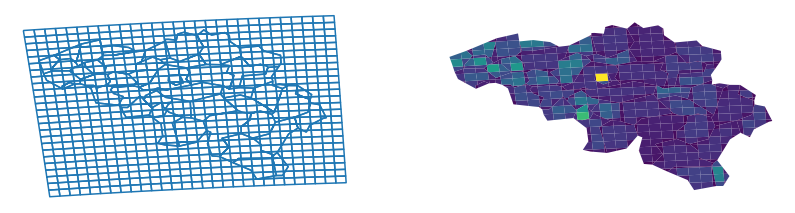

In [22]:
f, ax = mplt.subplots(1,2, figsize=(14,10))
#f, ax = mplt.subplots(1, figsize=_FIGSIZE_)
poly_union.boundary.plot(ax=ax[0])
poly_union.plot(column='pct_area', legend=False, ax=ax[1])  
#               legend_kwds={'label': "%age of coverage by model layer", 'orientation': "horizontal"})
ax[0].set_axis_off(); ax[1].set_axis_off()
# f.suptitle("Union operation over vector layers A and B")

### Vector layers overlay - Practical implementation / Algorithm<a id='Algorithm'></a>

Considering the actual sizes (numbers of vector features) of the model and grid layers A and B in real use-case, it is not possible to run practically the above operations (*cf.* Albrecht and Janine's approach: 1 week processing in QGis). 

Instead, we propose the following algorithm:
* **split both layers into tiles,** 
* **perform the "union" set operation for the tiles,** 
* **merge the results.** 

The idea here is to take advantage of:
* **map/reduce approach (*a.k.a* divide-and-conquer),**
* **spatial indexing for optimal joining of vector data.** 
* **parallelisation of the processing.**

Given the know size of the cells in the regular grid (`gridsize`), say we know we have to limit calculations to tiles with 5 x 5 cells maximum (*e.g.* because this is a critical limit):

In [23]:
def get_tile_size(nlimit, gridsize, bounds, buffer=0):  
    return get_grid_size(nlimit * gridsize, bounds, buffer=buffer)

def define_tiles_as_grid(nlimit, gridsize, bounds, buffer=None, crs=None): 
    # simply refurbhish the function used to build the regular grid...
    print("! consider defining the tile by union instead !")
    return build_regular_grid(nlimit * gridsize, bounds, buffer=buffer, crs = crs)

NLIMIT = 5
tiles = define_tiles_as_grid(NLIMIT, GRIDSIZE, [xmin, ymin, xmax, ymax], 
                             buffer=GRIDSIZE, crs={'init': 'epsg:%s' % IPROJ}) 

tiles = tiles.to_crs({'init': 'epsg:%s' % OPROJ})
tiles.head(5)

! consider defining the tile by union instead !


/Library/miniconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,geometry
0,"POLYGON ((2.33476 51.49473, 3.05203 51.53965, ..."
1,"POLYGON ((2.40920 51.04813, 3.11962 51.09255, ..."
2,"POLYGON ((2.48189 50.60142, 3.18561 50.64535, ..."
3,"POLYGON ((2.55287 50.15459, 3.25006 50.19805, ..."
4,"POLYGON ((2.62221 49.70764, 3.31300 49.75064, ..."


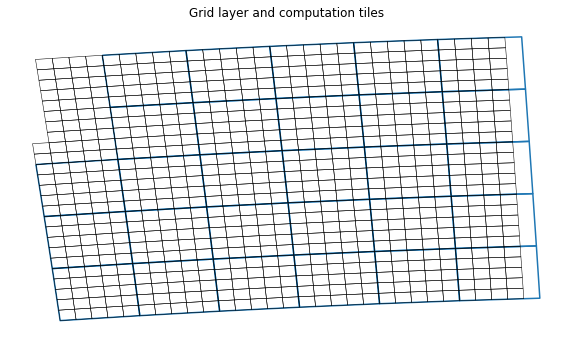

In [24]:
f, ax = mplt.subplots(1, figsize=_FIGSIZE_)
tiles[2:].boundary.plot(ax=ax)
grid[8:].boundary.plot(ax=ax, edgecolor='k', linewidth=0.5)
ax.set_axis_off(); ax.set_title('Grid layer and computation tiles')
mplt.show()

Another way to build the tiling consists in merging (dissolving) the grid cells according to the desired pattern:

/Library/miniconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


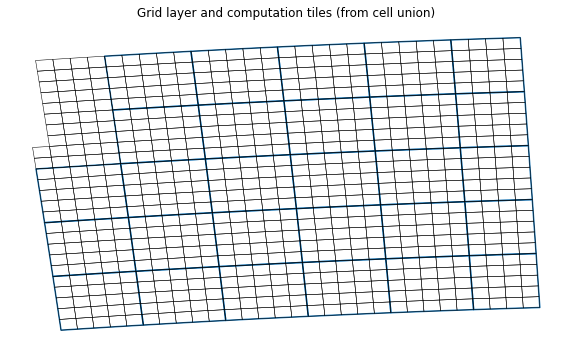

In [25]:
def get_tile_shape(nlimit, gridsize, bounds, buffer=0):
    xmin, ymin, xmax, ymax = bounds
    nxtiles = abs(int(np.ceil((xmax-xmin+2*buffer) / (nlimit*gridsize))))  # cols
    nytiles = abs(int(np.ceil((ymax-ymin+2*buffer) / (nlimit*gridsize))))  # rows
    return nytiles, nxtiles 

def get_tile_grid_items(x, y, nrows, ncols, nlimit):
    lenght = nrows*ncols -1
    index = [(x*nlimit+i)*nrows + (y*nlimit + j) for j in range(nlimit) for i in range(nlimit)]
    return [ind for ind in index if ind<=lenght]

def define_tiles_as_union(grid, nlimit, gridsize, bounds, buffer=None): 
    xmin, ymin, xmax, ymax = bounds
    buffer = gridsize if buffer is True else (0 if buffer in (False,None) else buffer)
    nytiles, nxtiles = get_tile_shape(nlimit, gridsize, [xmin, ymin, xmax, ymax], buffer)
    nrows, ncols = get_grid_shape(gridsize, bounds, buffer)   
    polytiles = []
    [polytiles.append(grid.iloc[get_tile_grid_items(x, y, nrows, ncols, nlimit)].unary_union) 
                     for x in range(nxtiles) for y in range(nytiles)] 
    tiles = gpd.GeoDataFrame({'geometry':polytiles})
    if grid.crs is not None:
        tiles.crs = grid.crs
    return tiles

utiles = define_tiles_as_union(grid, NLIMIT, GRIDSIZE, [xmin, ymin, xmax, ymax], BUFFER) 
utiles = utiles.to_crs({'init': 'epsg:%s' % OPROJ})

f, ax = mplt.subplots(1, figsize=_FIGSIZE_)
utiles[2:].boundary.plot(ax=ax)
grid[8:].boundary.plot(ax=ax, edgecolor='k', linewidth=0.5)
ax.set_axis_off(); ax.set_title('Grid layer and computation tiles (from cell union)')
mplt.show()

Let's define once for all (*i.e.* as global parameters) the dimension of the grid layer and the tiles. For each tile, we can retrieve the bounds that we will use to filter (clip) the vector layers A and B:

In [26]:
nrows, ncols = get_grid_shape(GRIDSIZE, [xmin, ymin, xmax, ymax], BUFFER)   
print('Grid actual shape:', (nrows, ncols))
nytiles, nxtiles = get_tile_shape(NLIMIT, GRIDSIZE, [xmin, ymin, xmax, ymax], BUFFER)
print('Tile actual shape:', (nytiles, nxtiles))
ntiles = len(tiles)

utiles.bounds.head(5)

Grid actual shape: (23, 27)
Tile actual shape: (5, 6)


,minx,miny,maxx,maxy
0,2.334756,51.048128,3.119625,51.539649
1,2.409202,50.601416,3.185614,51.092549
2,2.481888,50.154590,3.250056,50.645350
3,2.552872,49.707644,3.313001,50.198049
4,2.622212,49.260573,3.374500,49.750638


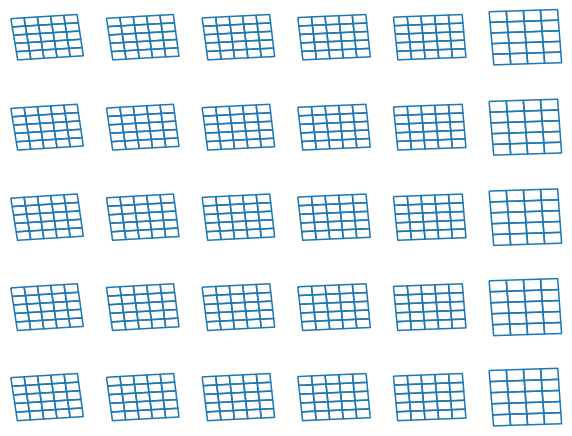

In [27]:
import warnings
warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)

def clip_by_bounds(index, grid, tiles):
    # clip by bounding box
    mask = gpd.GeoDataFrame([1], geometry=[tiles.geometry[index]], crs=tiles.crs)
    return gpd.clip(grid, mask, keep_geom_type=True)

def filter_by_bounds(index, grid, tiles):
    # filter grid using bounding box
    print("! consider filter by clipping instead !")
    xmin, ymin, xmax, ymax = tiles.bounds.loc[index,:].tolist()
    return grid.cx[xmin:xmax, ymin:ymax] # problem: returns those that intersect

f, ax = mplt.subplots(nytiles, nxtiles, figsize=_FIGSIZE_)

for y in range(nytiles):
    for x in range(nxtiles):
        index = x*nytiles + y
        if False:
            small_grid = filter_by_bounds(index, grid, utiles)
        else:
            small_grid = clip_by_bounds(index, grid, utiles)
        small_grid.boundary.plot(ax=ax[y,x])
        ax[y,x].set_axis_off() 
# f.suptitle('Grid layer and computation tiles')
mplt.show()

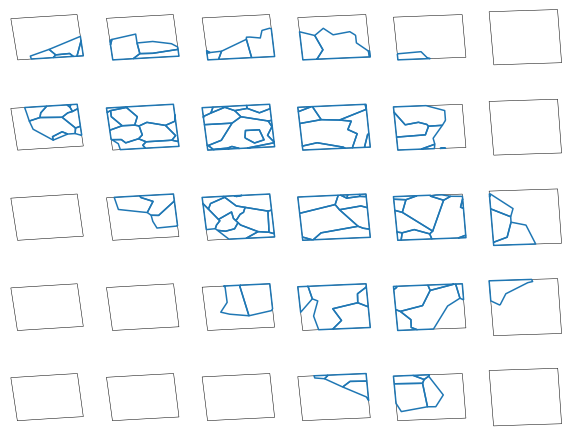

In [28]:
f, ax = mplt.subplots(nytiles, nxtiles, figsize=_FIGSIZE_)
for y in range(nytiles):
    for x in range(nxtiles):
        index = x*nytiles + y
        onetile = gpd.GeoDataFrame([1], geometry=[utiles.geometry[index]], crs=tiles.crs)
        res = gpd.overlay(polygons, onetile, how='intersection')
        onetile.boundary.plot(ax=ax[y,x], edgecolor='k', linewidth=0.5)
        if not res.is_empty.all():
            res.boundary.plot(ax=ax[y,x])
        ax[y,x].set_axis_off()
# f.suptitle('Tiled polygons')
mplt.show()

/Library/miniconda3/lib/python3.7/site-packages/geopandas/plotting.py:335: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


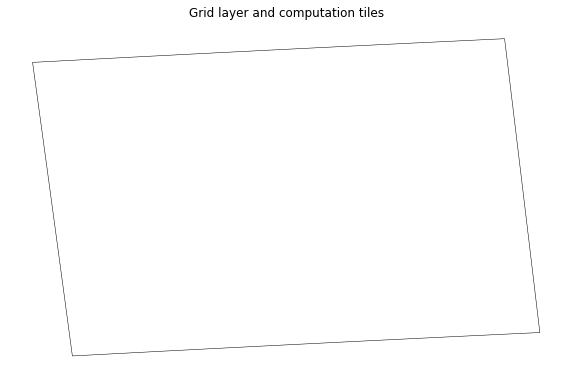

In [29]:
def intersects_tile(polygon, tile):
    return polygon.loc[polygon.intersects(tile)]
def within_tile(polygon, tile):
    return polygon.loc[polygon.within(tile)]

onetile = gpd.GeoDataFrame([1], geometry=[utiles.geometry[10]], crs=tiles.crs)
polygons.within(onetile)

res = intersects_tile(polygons, onetile)
f, ax = mplt.subplots(1, figsize=_FIGSIZE_)
#polygons.boundary.plot(ax=ax, edgecolor='k', linewidth=0.5)
onetile.boundary.plot(ax=ax, edgecolor='k', linewidth=0.5)
res.boundary.plot(ax=ax, edgecolor='k', linewidth=0.5)

ax.set_axis_off(); ax.set_title('Grid layer and computation tiles')
mplt.show()

In [ ]:
onetile = gpd.GeoDataFrame([1], geometry=[utiles.geometry[10]], crs=tiles.crs)

res = gpd.overlay(polygons,onetile, how='intersection')
# res = polygons.intersects(onetile.geometry)
#print(res.any())
f, ax = mplt.subplots(1, figsize=_FIGSIZE_)
#polygons.boundary.plot(ax=ax, edgecolor='k', linewidth=0.5)
onetile.boundary.plot(ax=ax, edgecolor='k', linewidth=0.5)
res.boundary.plot(ax=ax, edgecolor='k', linewidth=0.5)

ax.set_axis_off(); ax.set_title('Grid layer and computation tiles')
mplt.show()

### Alternative solution: rasterisation

This is actually a coarse approximation since you will get a unique polygon ID per grid cell. The quality/accuracy of the approximation however improves with an increased resolution.